In [1]:
import torch
import torch.nn as nn
# import torch.optim as optim
import torch_optimizer as optim

import torch.nn.functional as F

from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


import os
import mne
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.interpolate import interp1d
import seaborn as sns; sns.set()



# custom codes
from fMRI_Regions import get_masked_fmri
from  original_input import create_dataset
import make_input
import methods

In [2]:
from utils.helpers  import *


# Download data 
- Download raw data without any preprocessing and alignments. Format (n_channels, time_lenght)
- Divide on Train and Test data 
- Create some datasets with on the fly processing 

In [3]:
eeg_path = '../data/eeg_fmri_data_trio_four_subjects/eeg_on/eeg_on_1.edf'
fmri_path = '../data/eeg_fmri_data_trio_four_subjects/fmri_on/fmri_on_1.nii'

## Read raw EEG 
- Read EEG files
- Apply band pass filter in region ( 5: 100)

fsadfjk

In [4]:
vector_exclude = ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6', 'Status']
raw = mne.io.read_raw_edf(eeg_path, exclude=vector_exclude)
eeg_raw = raw.get_data()

eeg = mne.filter.filter_data(eeg_raw ,sfreq=1000, l_freq=5, h_freq=100, verbose =False)
print('Size of eeg data:',  eeg.shape)

Extracting EDF parameters from D:\Work\HSE_project\EEG_fMRI\data\eeg_fmri_data_trio_four_subjects\eeg_on\eeg_on_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Size of eeg data: (30, 305000)


## Read raw fMRI

- Read fMRI files
- Extract some ROI regions
- Make interpolation 


Dimension of our raw fMRi data:  (61, 72, 61, 150)
Dimension of our ROI fMRi data:  (21, 150)
Make interpolation
Lenghts before: (21, 150) 
After: (21, 305000)


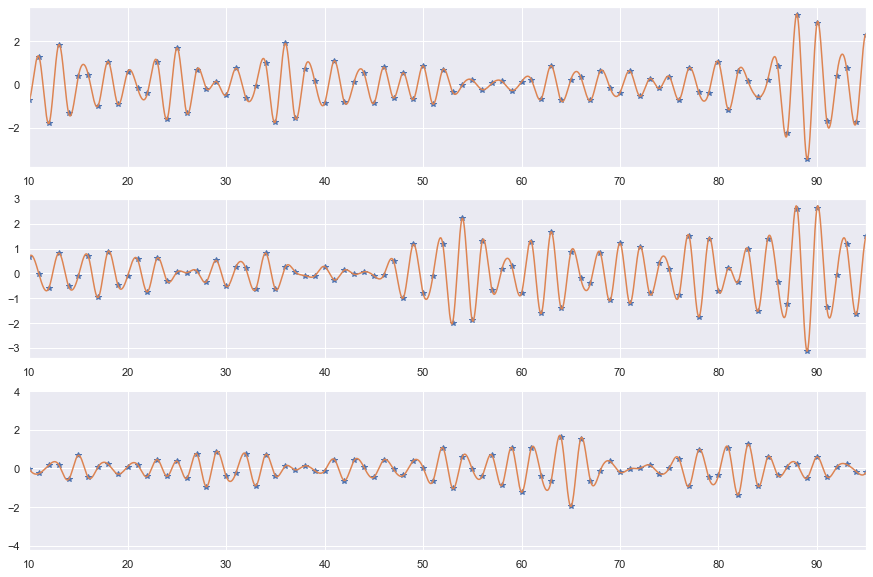

In [5]:
### Read fMRI and extract ROI 
from nilearn import image

fmri_raw = image.smooth_img(fmri_path, fwhm=6)
fmri_roi = get_masked_fmri(fmri_raw, "sub")

fmri_roi = fmri_roi.T

print('Dimension of our raw fMRi data: ', fmri_raw.shape)
print('Dimension of our ROI fMRi data: ', fmri_roi.shape)

#----------------------------------------------------------------#
### Apply interpolation for signals 
output_lenght = 305000
n_roi, time_step = fmri_roi.shape
x_new = np.linspace(0, time_step-1, output_lenght)

fmri_interp = interpolate_data(fmri_roi, output_lenght)

print('Make interpolation')
print('Lenghts before:', fmri_roi.shape, '\nAfter:', fmri_interp.shape)

#-----------------------------------------------------------------------#
### Visualisation

fig, ax = plt.subplots(3, 1, figsize = (15, 10))
for i, axi in enumerate(ax.flat):
    axi.plot(fmri_roi[i], '*')
    axi.plot(x_new, fmri_interp[i])
    axi.set_xlim((10, 95))






# Create training dataset
- Make some preprocessing 
    - normalize 
    - remove bad channels 
    - crop border
- DataGenerator with some property
    - delays
    - lenght of temporal information 
    - type of preprocess for eeg and fMRI:
        - RAW 
        - BANK filters
        - FFT 
        - Spectrogram
    - Type of augmentation 
    - 
- Divide on train/validate subset 
- Balance dataset


## Make some preprocessing 
    - crop border
    - normalize 
    - remove bad channels 
    - delay estimation.

In [6]:
def normalize(data, return_values = False):
    """ 
    data : [n_channels, t_step]
    Calculate mean and std for each cnahnels. Make transforamtion 
    """
    means = np.mean(data, axis = 1, keepdims=True)
    stds = np.std(data, axis = 1, keepdims=True)
    transform_data = (data - means)/stds
    if return_values:
        return transform_data, (means, stds)
    return transform_data

In [7]:

print('Crop started and some ended part. Cause we have some problem')
percent_start = 0.15
percent_end = 0.15


print('Size of EEG data: ', eeg.shape,
      '\nSize of fMRI data: :', fmri_interp.shape)

lenght = eeg.shape[-1]


start_point = int(lenght*percent_start)
end_point = int(lenght - lenght*percent_end)

eeg_crop = eeg[:, start_point:end_point]
fmri_interp_crop = fmri_interp[:, start_point:end_point]

print('After croppping: Size of EEG data: ', eeg_crop.shape,
      '\nSize of fMRI data: :', fmri_interp_crop.shape)



Crop started and some ended part. Cause we have some problem
Size of EEG data:  (30, 305000) 
Size of fMRI data: : (21, 305000)
After croppping: Size of EEG data:  (30, 213500) 
Size of fMRI data: : (21, 213500)


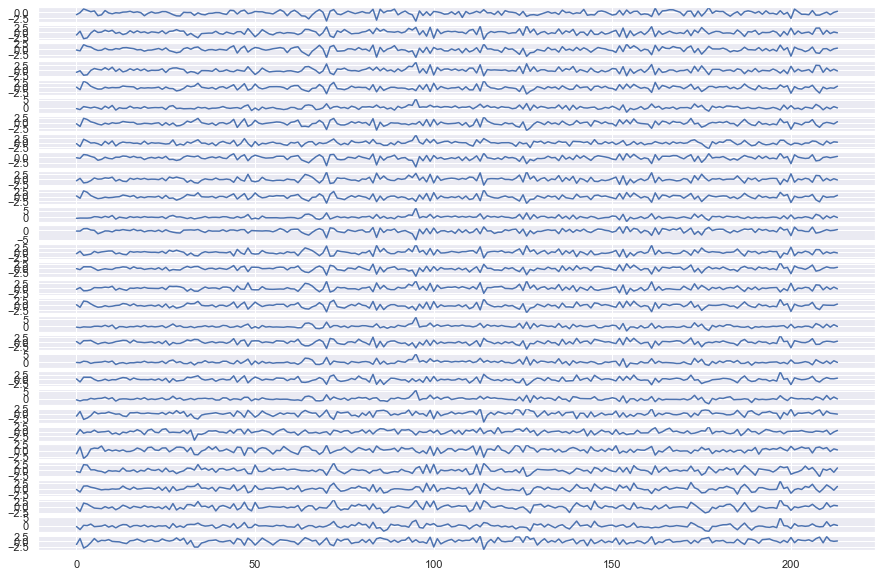

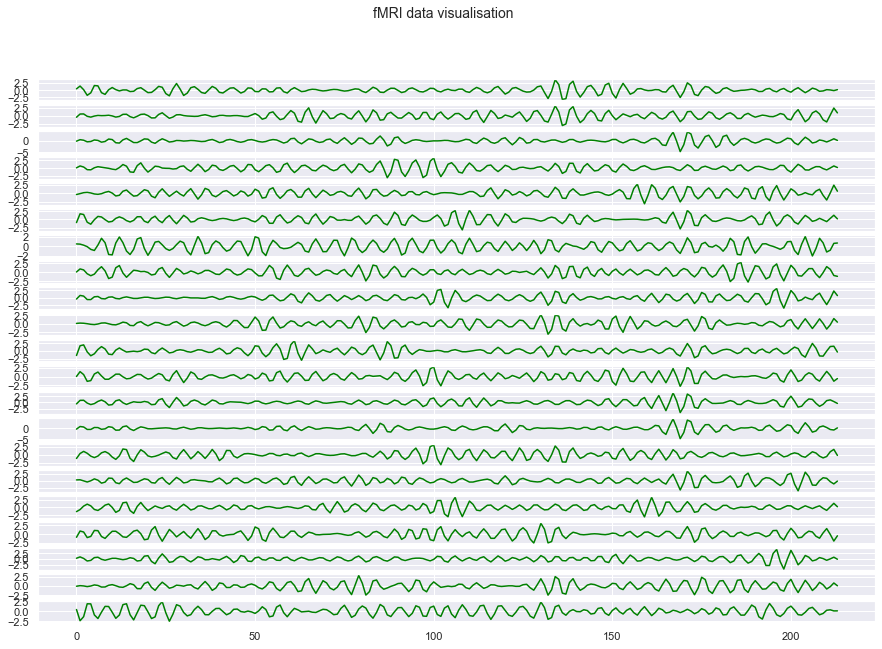

Result sizes (30, 213500) (21, 213500)


<Figure size 432x288 with 0 Axes>

In [8]:
eeg_norm = normalize(eeg_crop)
fmri_interp_norm = normalize(fmri_interp_crop)


fig.suptitle('EEG data visualisation', fontsize=14)
fig, ax = plt.subplots(eeg.shape[0], 1, figsize = (15, 10))
for i, axi in enumerate(ax.flat):
    axi.plot(eeg_norm[i, ::1000], '-')
plt.savefig('../images/EEG_data_visualisation.png')
plt.show()



fig, ax = plt.subplots(fmri_interp_norm.shape[0], 1, figsize = (15, 10))
fig.suptitle('fMRI data visualisation', fontsize=14)

for i, axi in enumerate(ax.flat):
    axi.plot(fmri_interp_norm[i, ::1000], '-', color = 'green')
#     axi.plot(x_new, fmri_interp[i])
#     axi.set_xlim((10, 95))

plt.show()
plt.savefig('../images/fMRI_data_visualisation.png')
# plt.plot(eeg[:, ::500].T)/



print('Result sizes', eeg_norm.shape, fmri_interp_norm.shape)

## DataGenerator with some property
    - delays
    - lenght of temporal information 
    - type of preprocess for eeg and fMRI:
        - RAW 
        - BANK filters
        - FFT 
        - Spectrogram
    - Type of augmentation 
    - 

In [9]:
from utils import datasets
from utils import process

# parameters_balanced = {'threshold': 1,
#                       'how_balanced': 'downsample',
#                       'set_bound': 1000,
#                       'add_rest': 500 }
#bank filters
# band_freqs =[[0.1, 4],
#              [8, 12],
#              [19, 20],
#              [24, 25],
#              [29, 30],
#              [51, 60],
#              [61, 70],
#              [71, 80],
#              [90, 110],
#              [120, 200]]
bank_filter_set = {'make_bank_filter': False,
                   'n_coefs': 28,
                   'band_freqs': []}
fft_set = {'make_fft': False,
           'WINDOW_SIZE': 0,
           'SHIFT': 0,
           'fs': 1000}


#---------------------------------------------------------------------------#



# output_set = {'make_box_transform': False,
#               'make_out_smooth': True,
#               'N_smooth': 80}

# classify_dict = {'classify' : False,
#                 'n_classes': 100,
#                 'smooth_out': False,
#                 'std_value': 0}


In [10]:
seconds = 3
time_delay = int(seconds*1000)
eeg_norm_delay, fmri_interp_norm_delay =  process.preprocess_data(eeg_norm.T, fmri_interp_norm.T, DELAY=time_delay)

In [11]:
shapes(eeg_norm.T, fmri_interp_norm.T)
shapes(eeg_norm_delay.T, fmri_interp_norm_delay.T)

[[30, 210500], [21, 210500]]

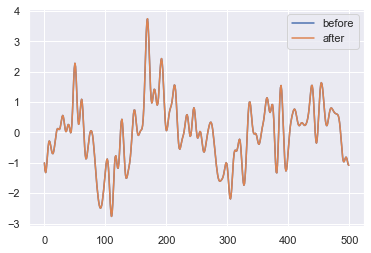

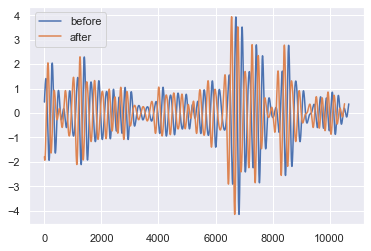

In [12]:
plt.plot(eeg_norm.T[:500, 0], label = 'before')
plt.plot(eeg_norm_delay[:500, 0], label = 'after')
plt.legend()
plt.show()
plt.plot(fmri_interp_norm.T[::20, 0], label = 'before')
plt.plot(fmri_interp_norm_delay[::20, 0], label = 'after')
plt.legend()

In [13]:
# """DATASET CREATION"""
# print('\n DATASET CREATION \n'
#      'Overlapping 8 seconds region')


# fft_set = {'make_fft': True,
#            'WINDOW_SIZE': 256,
#            'SHIFT': 128,
#            'fs': 1000, 
#            'freq_border': (0, 100) }


# hp = {  'stride': 32, # between data samples
#         'Tx':64,
#         'to_many':False,
#         'time_first':False,
#         'ratio_list': [0.7, 0.2, 0.1]}

# size_train_set =int(hp['ratio_list'][0]*eeg_norm.shape[1])
# # size_train_set


# classify_dict = {'classify' : False,
#                 'n_classes': 100,
#                 'smooth_out': False,
#                 'std_value': 0}



# data_tensors = datasets.datasets_creation(eeg_norm_delay, fmri_interp_norm_delay, 
#                                           fft_set=fft_set,
#                                           classify_dict=classify_dict, **hp)
                                          

# # dataset_train, dataset_val, dataset_test = [datasets.balanced_dataset(set, **hp.parameters_balanced) for set in data_tensors]

# # batch_size = 16
# # train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle=True)
# # val_loader = DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle=True)
# # test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle=False)

# # len(data_tensors[0])
# train_data = data_tensors[0]
# train_data

In [14]:
    
class CreateDatasetCustom(Dataset):
    """
    work with raw(it is unneccesary), many_to_many task
    - Input data with reduce delay between them
        x_tensor shapes [times, n_channels]
        y_tensor shapes [times, n_channels]
        
    - Tx (int) : size of window
    - stride (int) : which step between window
    
    - freq_border ; (min , max)
    - to_many (bool): seq_len of output.
        if to_many= True -> seq_len = seq_len
        if to_many= True -> seq_len = 1
    ----------------------------------------------------
    - Returns:  size = len(x_tensor)
        - if time_first = True
                X = [size, seq_len, n_channels]  # output -> [n_channel, n_features, seq_len(Tx)]
                Y = [size, seq_len, 1]
        - else
                X = [size, n_channels, 1, seq_len]
                Y = [size, seq_len, 1]
    """
    def __init__(self, x_tensor, y_tensor, Tx=60, to_many=True, stride=1, time_first=False,
                 make_fft = False, WINDOW_SIZE = 256, SHIFT = 32, fs = 1000, freq_border=(0, 100), 
                 classify = False, n_classes = 100, smooth_out= False, std_value = 0):

        self.Tx = Tx  #size of window
        self.stride = stride # which step between window
        self.time_first = time_first
        self.to_many = to_many

        self.x = x_tensor
        self.y = y_tensor
        
        # preprocessing X
        self.make_fft = make_fft
        self.SHIFT = SHIFT
        self.WINDOW_SIZE = WINDOW_SIZE
        self.fs = fs
        self.min_freq = freq_border[0]
        self.max_freq = freq_border[1]
        
        self.gap = (self.Tx-1)*self.SHIFT + self.WINDOW_SIZE #it is advansed WINDOW which we slide on input eeg data
        
        # settings classification task
        self.classify = classify
        self.min_value = y_tensor.min().item()
        self.max_value = y_tensor.max().item()
        self.n_classes = n_classes
        self.smooth_out = smooth_out
        self.std_value = std_value
    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError
        
        if self.make_fft:
            start_time = idx*self.stride
            
            
            # output -> [n_channel, n_features, seq_len(Tx)]
            freq, time, x = signal.spectrogram(self.x[start_time:start_time+self.gap].T,
                                               fs = self.fs, nperseg=self.WINDOW_SIZE,
                                               noverlap= self.WINDOW_SIZE- self.SHIFT)
            
            
            ### maximum and minimum freq bounding...
            idx_min = int(np.argwhere(freq > self.min_freq)[0])
            idx_max = int(np.argwhere(freq < self.max_freq)[-1])
            freq = freq[idx_min:idx_max]
            x = x[:, idx_min:idx_max, :]
            
            ### some normalization of Spectrogram
            x = np.log(x+0.0001)
            if self.time_first:
                X_dataset = x.transpose([2, 0, 1])
            else:
                X_dataset = x
            
            start_y = start_time
            end_y = start_time + self.gap
            Y_dataset = self.y[start_y:end_y, :]

        else:
            start_time = idx*self.stride
            end_time = start_time + self.Tx
            
            if self.time_first:
                X_dataset = self.x[start_time:end_time]
            else:
                X_dataset = self.x[start_time:end_time].T
#                 # are there any filters
#                 if len(self.x.shape)==3:
#                     X_dataset = X_dataset.permute(1,0,2)
#                 else:
#                     X_dataset = X_dataset.unsqueeze(dim = -2)
            Y_dataset = self.y[start_time:end_time]
        
        
        if self.to_many:
            Y_dataset = Y_dataset
        else:
            Y_dataset = Y_dataset[-1]  # do not want keep dimension

        if self.classify:
            Y_dataset = one_hot_encode(Y_dataset, self.n_classes, self.min_value, self.max_value,
                                       self.smooth_out, self.std_value)
        return (X_dataset, Y_dataset)
    
    def __len__(self):
        input_size = self.x.shape[0]
        if self.make_fft:
            output_size = (input_size - self.gap)//self.stride 
        else:
            output_size = (input_size - self.Tx)//self.stride
        return output_size
    def __repr__(self):
        info = []
        str1 = "\nPyTorch DataSet of our data. \nContain:\nX: " +str(shapes(self.x)) + '\nY: '+ str(shapes(self.y))
        str_par = '\nParameters:'
        str2 = "\n- MANY_TO_MANY: " + str(self.to_many)
        str2a = "\n- Advanced lenght of time for FFT only(gap): " + str(self.gap)
        str3 = "\n- Lenght of time(Tx): " + str(self.Tx)
        str4 = "\n- Step(stride): " + str(self.stride)
        str4_a = "\n- time_first: " + str(self.time_first)
        x, y = self[0]
        str5 = '\nOutput:\nSize of dataset: ' + str(len(self))
        str6 = '\nX: ' + str(shapes(x)) + '\nY: ' +  str(shapes(y))
        return str1 + str_par + str2 +str2a+ str3 + str4 +str4_a+ str5 + str6


In [15]:
# fft_set = {'make_fft': True,
#            'WINDOW_SIZE': 256,
#            'SHIFT': 16,
#            'fs': 1000, 
#            'freq_border': (0, 100) }

# hp_custom = {  'stride': 10, # between data samples
#                 'Tx':32,
#                 'to_many':False, 
#                 'time_first':False,}


# custom_data = CreateDatasetCustom(eeg_norm_delay[10000:20000], fmri_interp_norm_delay[10000:20000], 
#                                   **fft_set, **classify_dict, **hp_custom)
# # x, y  = custom_data[0]
# # print(custom_data, '\n', shapes(x, y))
# custom_data


In [16]:

# fft_set = {'make_fft': True,
#            'WINDOW_SIZE': 256,
#            'SHIFT': 16,
#            'fs': 1000, 
#            'freq_border': (0, 100) }

# hp_custom = {  'stride': 10, # between data samples
#                 'Tx':32,
#                 'to_many':False, 
#                 'time_first':False,}


# custom_data = CreateDatasetCustom(eeg_norm_delay[10000:20000], fmri_interp_norm_delay[10000:20000], 
#                                   **fft_set, **classify_dict, **hp_custom)
# # x, y  = custom_data[0]
# # print(custom_data, '\n', shapes(x, y))


# batch_size = 4
# train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)
# val_loader = DataLoader(dataset = val_data, batch_size = 1, shuffle=False)

In [17]:
# x, y = train_data[1000]
# print('Size of sample', shapes(x, y))

# # plt.title('Sample EEG data')
# # _ = plt.plot(x[:,:])
# # plt.show()


# fig, ax = plt.subplots(3,figsize = (5, 5), sharex=True )
# # plt.figure(figsize = (5, 5))
# # fig.title('Sample freq EEG data')

# ax[0].imshow(x[0, :])
# ax[0].set_title('Channel ' +str(0))
# ax[1].imshow(x[10, :])
# ax[1].set_title('Channel ' +str(10))
# ax[2].imshow(x[25, :])
# ax[2].set_title('Channel ' +str(25))

# # fig.colorbar()

# plt.show()

# # plt.figure(figsize = (20, 30))
# # plt.imshow(data_tensors[0][10][0][:, 4, :].T)
# _, y_2 = train_data[2000]

# plt.title('Sample fMRI data')
# _ = plt.plot(y[:,:].T)
# _ = plt.plot(y_2[:,:].T)

## Divide on train/validate subset 


In [18]:
import pytorch_model_summary as pms

In [19]:
def pearsonr(x, y, batch_first=True):
    r"""Computes Pearson Correlation Coefficient across rows.
    """ 
    assert x.shape == y.shape

    if batch_first:
        dim = -1
    else:
        dim = 0

    centered_x = x - x.mean(dim=dim, keepdim=True)
    centered_y = y - y.mean(dim=dim, keepdim=True)

    covariance = (centered_x * centered_y).sum(dim=dim, keepdim=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(dim=dim, keepdim=True)
    y_std = y.std(dim=dim, keepdim=True)

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr

# Training stage


## Function for training script

### Metrics for vectors
- l2
- l1 
- correlation

In [20]:
def l2_metric(x, y):
    assert x.shape == y.shape
    res = np.mean((x-y)**2)
    return res

def l1_metric(x, y):
    assert x.shape == y.shape
    res = np.mean(np.abs(x-y))
    return res

def correlation_metric(x, y):
    """
    
    """
    assert x.shape == y.shape
    x_central = x - x.mean()
    y_central = y - y.mean()
    
    cov = (x_central * y_central).sum()
    
    std_x = (x_central ** 2).sum()
    std_y = (y_central ** 2).sum()
    
    r = cov/np.sqrt(std_x*std_y)
    
    return r

- **make_inference**. Take model and dataset w/o shuffle. Return prediction in numpy array format
- **calculate_metric**. INput  prediction and gt. Compare based on some metrics and make it for croppin with certain size.
        Return -> metric1 and metric 2 with shape (n_feature, lenght_crop)

In [21]:
def make_inference(model, dataset, device='cpu'):
    """
    CHANGE FOR INFERENCE FROM DATASET
    Suppose that batch size  = len(test_data)
    return: vector of predictions and true value in numpy arrays
    
    test_loader- should be no overlappinh and w/o any shuffle.
    Just sequence data.
    
    Outputs of model is [channels]
    
    Returns: 
    y_hat, y_true the fist is time lenght
    Prediction 
    """
    model.to(device); model.eval()
#     batch_size = test_loader.batch_size
    size = len(dataset)
    
    counter = 0
    y_hat_list = []
    y_true_list = []
    with torch.no_grad():
        for i in range(size):
            x_batch, y_batch = dataset[i]
            x_batch = torch.from_numpy(x_batch).float().to(device)
            y_batch = torch.from_numpy(y_batch).float().to(device)
            
            x_batch = torch.unsqueeze(x_batch, 0)
            
            counter += 1
            out = model(x_batch)
            y_hat_list.append(out[0])
            y_true_list.append(y_batch)
            
#     torch.cat(y_hat_list, 0).numpy()
    y_hat = torch.stack(y_hat_list, 0).numpy()
    y_true = torch.stack(y_true_list, 0).numpy()
    
    return y_hat, y_true




def calculate_metric(y_hat, y_true, func_metric_1, func_metric_2, crop_lenght = None ):
    """
    Inputs:
        func_metric_1, func_metric_2 
        are fucnction that calculate some regression metrics for two time serias
    numpy array
    y_hat, y_true have shapes [time_lenght, feature]
    calculate correlation and mse metrics.
    crop on parts and make average estimation.
    if crop_percent=1 we obtain one value for each feature
    ---------------------------------------
    Returns:
    metrics with shape metric for each feature and for each crop [n_feature, n_crops]
    """
    time_lenght = y_hat.shape[0]
    if crop_lenght is None:
        crop_lenght = time_lenght
    
    n_feature = y_hat.shape[-1]
    metrics_1 = [[] for i in range(n_feature)] 
    metrics_2 = [[] for i in range(n_feature)]
    
#     crop_lenght = int(time_lenght * crop_percent)
    n_crops = time_lenght//crop_lenght
    
    # we divide time serias on crop wiht certain lenght. It allows estimate scatter 
    # and understand stability of algorith.
    for i in range(n_crops):
        y_hat_crop = y_hat[i*crop_lenght: (i+1)*crop_lenght]
        y_true_crop = y_true[i*crop_lenght: (i+1)*crop_lenght]
        
        for n_feature in range(y_hat_crop.shape[-1]):
            
            metric_1 = func_metric_1(y_hat_crop[:, n_feature], y_true_crop[:, n_feature])
            metric_2 = func_metric_2(y_hat_crop[:, n_feature], y_true_crop[:, n_feature])
#             print(metric_1, metric_2)

            metrics_1[n_feature].append(metric_1)
            metrics_2[n_feature].append(metric_2)
            
    
    return np.concatenate(metrics_1), np.concatenate(metrics_2) 
    

## Training script

In [22]:
def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    file_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, file_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        copyfile(file_path, best_fpath)

def load_checkpoint(model, filepath, freeze_param =True):
    checkpoint = torch.load(filepath)
    # model = checkpoint['model']
    model.load_state_dict(checkpoint)
    if freeze_param:
        for parameter in model.parameters():
            parameter.requires_grad = False
    model.eval()
    return model





def train_regression(EPOCHS, model, train_loader, val_dataset,
                     loss_function, train_step, optimizer, func_metric_1, func_metric_2,
                     filepath, device, writer, show_info=10, num_losses=3):
    model = model.to(device)
    batch_size = train_loader.batch_size
    min_loss = 10000000000

    print("Starting Training of our model",
          "\nNumber of samples", batch_size*len(train_loader),
          "\nSize of batch:", batch_size, "Number batches", len(train_loader))

    #-----------------------------------------------------------------------#

    for epoch in range(EPOCHS):
        model = model.to(device)
        counter = 0
        sum_losses =[ 0 for i in range(num_losses)]
        # training
        model.train()
        for x_batch, y_batch in train_loader:
            
            counter += 1
            print('.', sep=' ', end='', flush=True)
            
            x_batch = x_batch.to(device, dtype=torch.float)
            y_batch = y_batch.to(device, dtype=torch.float)
            
            losses = train_step(x_batch, y_batch, model, loss_function,
                                optimizer, device)
                        
        ### add to tensorboard all losses.
        for i in range(len(losses)):
            sum_losses[i] += losses[i].item()
            writer.add_scalar("Loss_"+ str(i), losses[i]/counter, epoch)
                
        #-------------------------------------------------------------------------------#
        if epoch % show_info == 0:
            ### training logging. printing all losses/
            general_out_ = 'Epoch {} '.format(epoch)
            for i in range(len(sum_losses)):
                tmp_string = 'Average train loss_{} : {:.3} '.format(i, sum_losses[i]/counter) 
                general_out_ += tmp_string
            print(general_out_)
            
            
            ### validation logging for all validation data.
            with torch.no_grad():
                model.eval()
                val_loss = []
                val_corr = []

                y_hat, y_true = make_inference(model, val_dataset)
                val_mse, val_corr = calculate_metric(y_hat, y_true, func_metric_1, func_metric_2)
                val_mse = np.mean(val_mse)
                val_corr = np.mean(val_corr)

                out_string = 'val_loss: {:.2}: val_corr: {:.2}'.format(val_mse, val_corr)
                print(out_string)
            
                # make visualisation of val_loader prediction.
                figure = plt.figure(figsize = (8, 8))
                plt.plot(y_hat[:, 0], label = 'prediction')
                plt.plot(y_true[:, 0], label = 'true')
                plt.legend()
                plt.show()
                
                writer.add_scalar("Validation loss", val_mse, epoch)
                writer.add_scalar("Validation corr", val_corr, epoch)
                writer.add_figure("Visualisation/test", figure, epoch)
                
#                 figure = plt.figure(figsize = (5, 5))
#                 plt.plot(y_hat[100, :], label = 'prediction')
#                 plt.plot(y_true[100, :], label = 'true')
#                 plt.legend()
#                 plt.show()

                    
        # Save model parameters

        # model_tmp = model.to('cpu')
        checkpoint = model.state_dict()
                  
        if val_mse < min_loss:
            min_loss = val_mse
            save_checkpoint(checkpoint, True, filepath[0], filepath[1])
        else:
            save_checkpoint(checkpoint, False, filepath[0], filepath[1])

    return model


## Loss function and train step

In [23]:
def make_loss_function():
    """
    Create loss fucntion for working with [x_batch, y_batch, y_hat] 
    """
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
#     criterion_corr = pearsonr
    def loss_func(x_batch, y_batch, y_hat):

        mse_loss = criterion_mse(y_hat, y_batch)
        mae_loss = criterion_mae(y_hat, y_batch)
        
        total_loss = mse_loss 
        return mse_loss, mse_loss, mae_loss
    return loss_func

    
def train_step(x_batch, y_batch, model, loss_function, optimizer, device = 'gpu'):
    """
    Make train step. updates weight from model.
    
    Inputs:
    x_batch, y_batch, model should be on the same device. 
    model should be in train mode.
    loss_function is function that take x_batch, y_batch, y_hat and calculate some loss function. 
    Returns:
    Losses for batch_size() 
    """    
    ### translate to the same device    
    
    optimizer.zero_grad()
    y_hat = model(x_batch)
    losses = loss_function(x_batch, y_batch, y_hat)
    losses[0].backward()
    optimizer.step()
    
    return losses
    
    

# Model 

In [24]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset
from torch.utils.data.dataset import random_split

    
class ConvNetwork(nn.Module):
    def __init__(self, num_elctrode=30, num_filters=32, n_output=21):
        super(ConvNetwork, self).__init__()

        self.conv1_1 = nn.Conv2d(num_elctrode, num_filters, kernel_size=3,padding=1,stride=1)
        self.conv1_2 = nn.Conv2d(num_filters, num_filters*4, kernel_size = (3, 3),padding=1, stride = (1,1))
        self.pool_1 = nn.MaxPool2d((2,2))
        
        self.conv2_1 = nn.Conv2d(num_filters, num_filters*2, kernel_size = (3, 3), padding=1, stride = (1,1))
        self.conv2_2 = nn.Conv2d(num_filters*2, num_filters*2, kernel_size = (3, 3),padding=1, stride = (1,1))
        self.pool_2 = nn.MaxPool2d((2,2))
        
        self.conv3_1 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size = (3, 3), padding=1, stride = (1,1))
        self.conv3_2 = nn.Conv2d(num_filters*4, num_filters*4, kernel_size = (3, 3),padding=1, stride = (1,1))
        self.pool_3 = nn.MaxPool2d((2,2))
        
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        self.flat = nn.Flatten()
        
        self.classify_1 = nn.Linear(num_filters*4, num_filters*16)
        self.classify_2 = nn.Linear(num_filters*16, num_filters*4)
        self.classify_3 = nn.Linear(num_filters*4, n_output)



    def forward(self, x):
        # first layer
        # first stage
        x = self.conv1_1(x)
        x = torch.relu(x)
        x = self.conv1_2(x)
        x = torch.relu(x)
        x = self.pool_1(x)
        
        # second stage with residuals.
#         res_branch = self.conv2_1(x)
#         x = torch.relu(res_branch)
#         x = self.conv2_2(x)
#         x = torch.relu(x)        
#         x = x + res_branch
#         x = self.pool_2(x)
        
        # third stage with residuals.
#         res_branch = self.conv3_1(x)
#         x = torch.relu(res_branch)
#         x = self.conv3_2(x)
#         x = torch.relu(x)        
#         x = x + res_branch
#         x = self.pool_3(x)
        
        x = self.gap(x)
        x = self.flat(x)
        x = self.classify_1(x)
        x = torch.relu(x)
        x = self.classify_2(x)
        x = torch.relu(x)
        x = self.classify_3(x)        
        
        return x

# Initialize training process

In [25]:
import torch_optimizer as optim


In [26]:
model = ConvNetwork(30, num_filters=16, n_output=21)

loss_func = make_loss_function()
learn_rate = 0.001

optimizer = optim.Ranger(
    model.parameters(),
    lr=learn_rate,
    alpha=0.5,
    k=6,
    N_sma_threshhold=5,
    betas=(.95, 0.999),
    eps=1e-5,
    weight_decay=0
)
# optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)




In [27]:
# train_data, val_data, test_data = data_tensors
classify_dict = {'classify' : False,
                'n_classes': 100,
                'smooth_out': False,
                'std_value': 0}


fft_set = {'make_fft': True,
           'WINDOW_SIZE': 256,
           'SHIFT': 16,
           'fs': 1000, 
           'freq_border': (0, 100) }

hp_custom = {  'stride': 4, # between data samples
                'Tx':32,
                'to_many':False, 
                'time_first':False,}


hp_val= {  'stride':10, # between data samples
                'Tx':32,
                'to_many':False, 
                'time_first':False,}


custom_data = CreateDatasetCustom(eeg_norm_delay[5000:], fmri_interp_norm_delay[5000:], 
                                  **fft_set, **classify_dict, **hp_custom)

validate_custom_data = CreateDatasetCustom(eeg_norm_delay[:5000], fmri_interp_norm_delay[:5000], 
                                  **fft_set, **classify_dict, **hp_val)

print(len(custom_data))
print(custom_data)


batch_size = 128
train_loader = DataLoader(dataset = custom_data, batch_size = batch_size, shuffle=True)
# val_loader = DataLoader(dataset = val_data, batch_size = 1, shuffle=False)

51187

PyTorch DataSet of our data. 
Contain:
X: [[205500, 30]]
Y: [[205500, 21]]
Parameters:
- MANY_TO_MANY: False
- Advanced lenght of time for FFT only(gap): 752
- Lenght of time(Tx): 32
- Step(stride): 4
- time_first: False
Output:
Size of dataset: 51187
X: [[30, 24, 32]]
Y: [[21]]


In [28]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('model_runs/model_new_more_data')

filepath = 'model_tmp_new_more_data.pth'
filepath_best = 'model_last_new_more_data.pth'
save_path = [filepath, filepath_best]

Starting Training of our model 
Number of samples 51200 
Size of batch: 128 Number batches 400
.

D:\Programmsr\Anaconda3\envs\brain_torch\lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


...............................................................................................................................................................................................................................................................................................................................................................................................................Epoch 0 Average train loss_0 : 0.00265 Average train loss_1 : 0.00265 Average train loss_2 : 0.00197 
val_loss: 0.55: val_corr: 0.064


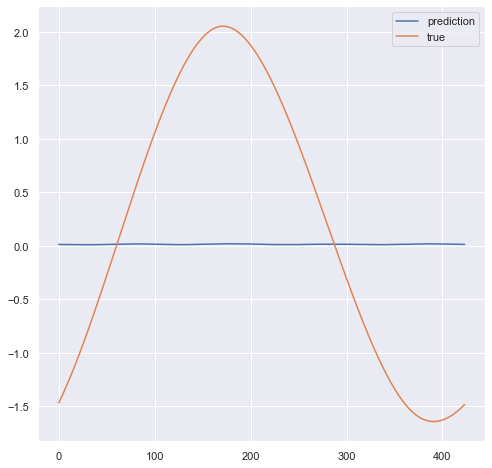

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 1 Average train loss_0 : 0.00244 Average train loss_1 : 0.00244 Average train loss_2 : 0.00188 
val_loss: 0.55: val_corr: 0.025


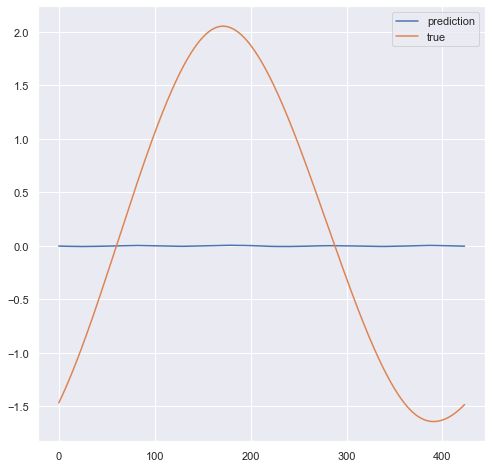

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 2 Average train loss_0 : 0.00244 Average train loss_1 : 0.00244 Average train loss_2 : 0.00189 
val_loss: 0.55: val_corr: -0.09


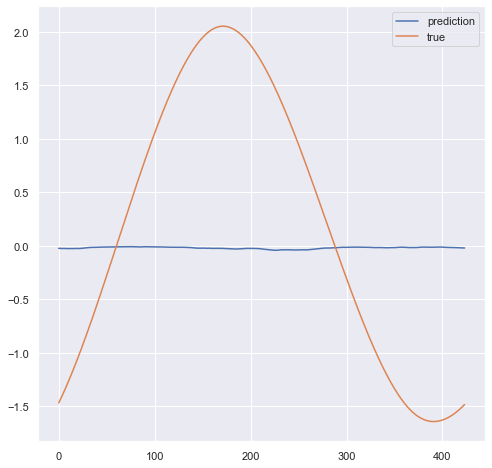

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 3 Average train loss_0 : 0.00232 Average train loss_1 : 0.00232 Average train loss_2 : 0.00184 
val_loss: 0.61: val_corr: -0.16


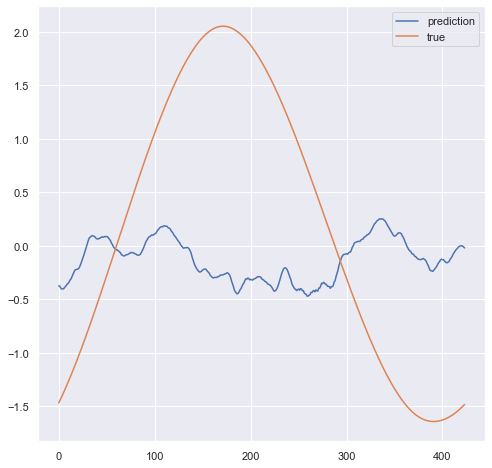

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 4 Average train loss_0 : 0.00229 Average train loss_1 : 0.00229 Average train loss_2 : 0.00185 
val_loss: 0.68: val_corr: -0.17


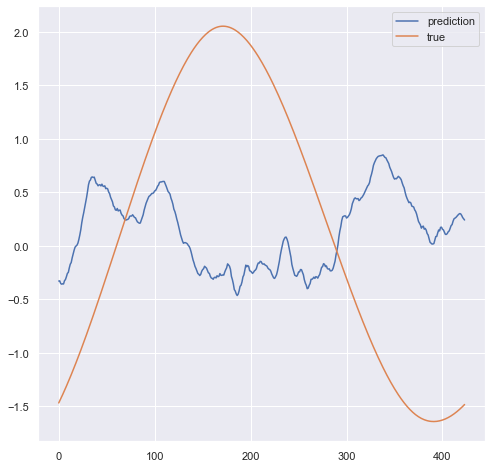

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 5 Average train loss_0 : 0.00258 Average train loss_1 : 0.00258 Average train loss_2 : 0.00199 
val_loss: 0.69: val_corr: -0.18


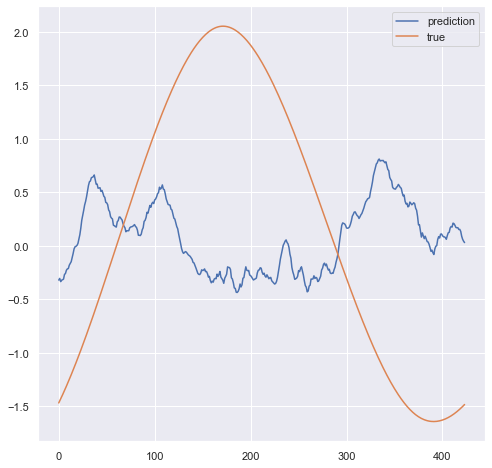

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 6 Average train loss_0 : 0.00192 Average train loss_1 : 0.00192 Average train loss_2 : 0.0017 
val_loss: 0.73: val_corr: -0.16


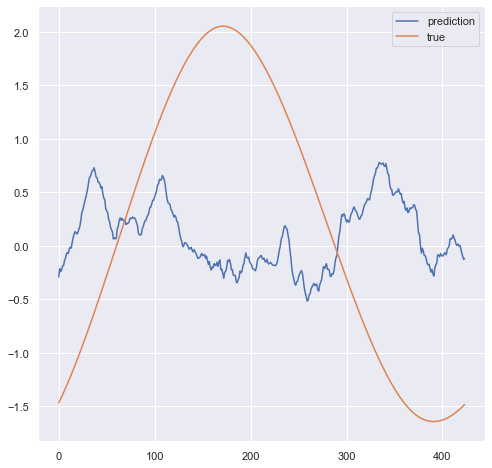

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 7 Average train loss_0 : 0.00186 Average train loss_1 : 0.00186 Average train loss_2 : 0.00166 
val_loss: 0.74: val_corr: -0.12


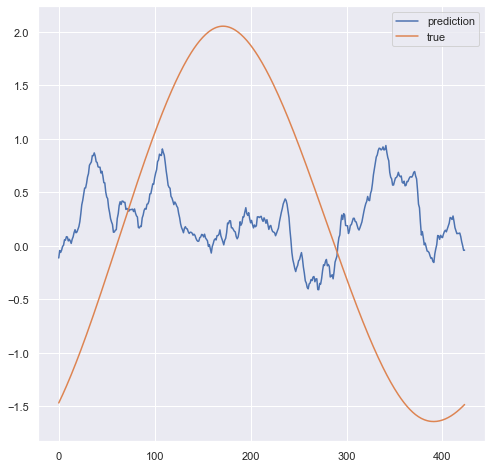

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 8 Average train loss_0 : 0.00165 Average train loss_1 : 0.00165 Average train loss_2 : 0.00158 
val_loss: 0.75: val_corr: -0.15


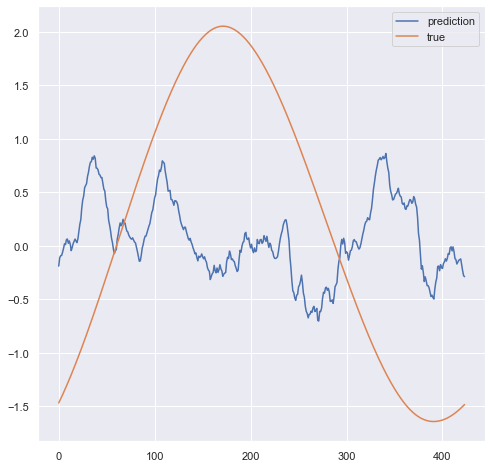

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 9 Average train loss_0 : 0.00171 Average train loss_1 : 0.00171 Average train loss_2 : 0.0016 
val_loss: 0.77: val_corr: -0.17


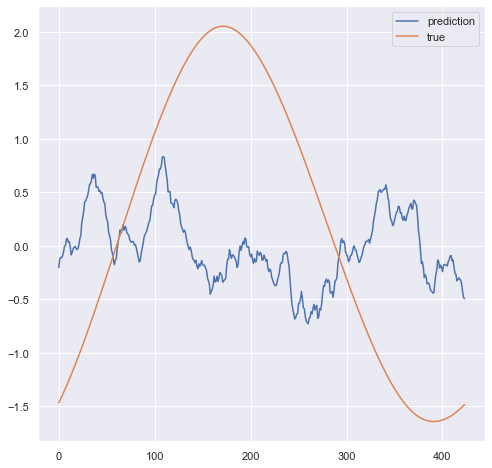

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 10 Average train loss_0 : 0.00166 Average train loss_1 : 0.00166 Average train loss_2 : 0.00159 
val_loss: 0.81: val_corr: -0.16


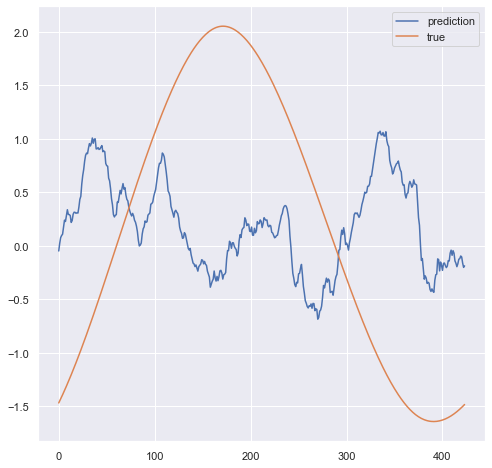

................................................................................................................................................................................................................................................................................................................................................................................................................Epoch 11 Average train loss_0 : 0.00154 Average train loss_1 : 0.00154 Average train loss_2 : 0.00153 
val_loss: 0.8: val_corr: -0.16


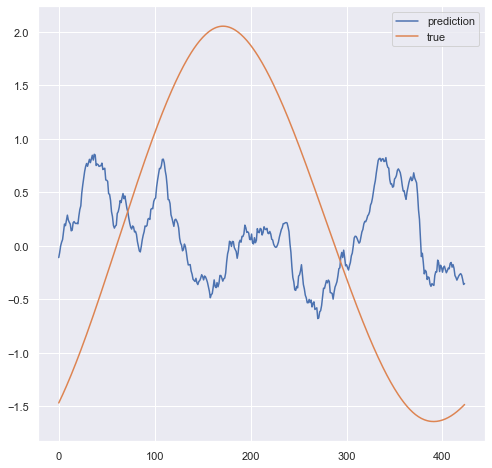

................................................................................................................................................................................................................................................................................................................................................

In [ ]:

parameters = {
    'EPOCHS':1000,
    'model':model, 
    'train_loader': train_loader, 
    'val_dataset': validate_custom_data, 
    'loss_function': loss_func,
    'func_metric_1': l2_metric,
    'func_metric_2':correlation_metric, 
    'train_step': train_step,
    'optimizer': optimizer,
    'filepath': save_path, 
    'device': 'cuda', 
    'num_losses':3, 
    'writer': writer,
    'show_info': 1,
    
}
model = train_regression(**parameters)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('model_runs/model1')

# *Visualization

In [ ]:
model_pre_trained = load_checkpoint(model, 'model.pth')

## Training data


In [ ]:
y_hat, y_true = make_inference(model_pre_trained, custom_data)

In [ ]:
print(shapes(y_hat, y_true))
metrics = calculate_metric(y_hat, y_true, 
                               func_metric_1=l2_metric, func_metric_2=correlation_metric )

print(sorted(metrics[1]))

In [ ]:
N = 10
plt.plot(y_hat[:, N])
plt.plot(y_true[:, N])

## Validation data


In [ ]:
validate_custom_data = CreateDatasetCustom(eeg_norm_delay[:10000], fmri_interp_norm_delay[:10000], 
                                  **fft_set, **classify_dict, **hp_custom)

In [ ]:
y_hat_val, y_true_val = make_inference(model_pre_trained, validate_custom_data)

In [ ]:
N = 12
plt.plot(y_hat_val[:, N])
plt.plot(y_true_val[:, N])

In [ ]:
metrics_val = calculate_metric(y_hat_val, y_true_val, 
                               func_metric_1=l2_metric, func_metric_2=correlation_metric )

In [ ]:
metrics_val[1]